**Initialization**

In [1]:
import numpy as np
from sklearn.manifold import TSNE

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

**Task 1: Data set**

Training inputs shape: (60000, 28, 28)
Training labels shape: (60000,)
Test inputs shape: (10000, 28, 28)
Test labels shape: (10000,)


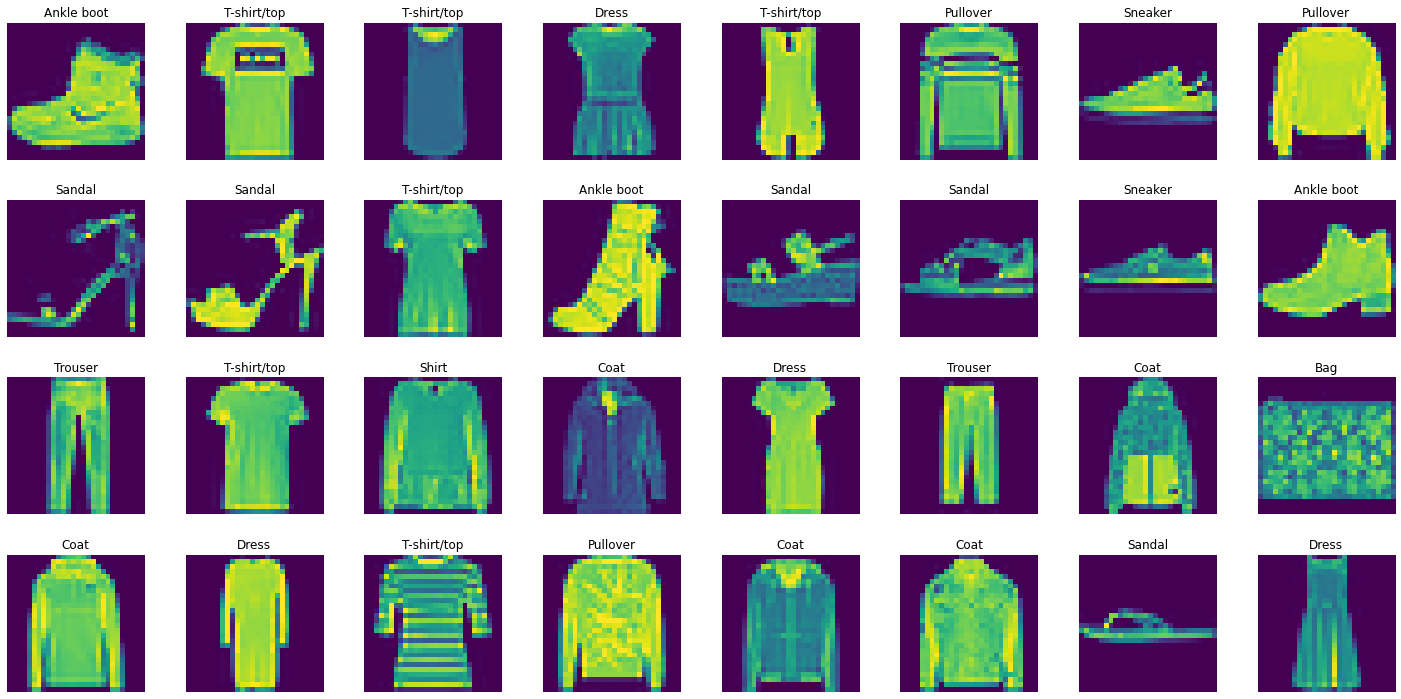

In [2]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

Input pipeline.

In [3]:
batch_size = 50

# Creates tensorflow datasets for the training and test inputs (images) and labels.
training_dataset_inputs = tf.data.Dataset.from_tensor_slices(training_inputs)
training_dataset_labels = tf.data.Dataset.from_tensor_slices(training_labels)
test_dataset_inputs = tf.data.Dataset.from_tensor_slices(test_inputs)
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)

# Adds an additional dimension to the input images (necessary for the convolutional layers).
training_dataset_inputs = training_dataset_inputs.map(lambda img : tf.expand_dims(img, -1))
test_dataset_inputs = test_dataset_inputs.map(lambda img : tf.expand_dims(img, -1))

# Zips together the training and test datasets.
training_dataset = tf.data.Dataset.zip((training_dataset_inputs, training_dataset_labels))
test_dataset = tf.data.Dataset.zip((test_dataset_inputs, test_dataset_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
training_dataset = training_dataset.map(lambda inp, tar: ((inp/255), tar))  
test_dataset = test_dataset.map(lambda inp, tar: ((inp/255), tar))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

In [4]:
#training_dataset = training_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))
#for inp, tar in training_dataset:
#  print(tar[0].numpy()) 
#  plt.imshow(tf.squeeze(inp[0]).numpy())
#  plt.show()

**Task 2: Model**

**Task 2.1: Convolutional Autoencoder**

Class Encoder

In [5]:
# Description: The class Encoder defines the encoder of a convolutional autoencoder.
class Encoder(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Encoder, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filters = 80,
                                         kernel_size = 3,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                         bias_initializer = 'zeros',                               
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),      
                                         input_shape = (28, 28, 1))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.relu    
    self.conv_2 = tf.keras.layers.Conv2D(filters = 80,
                                         kernel_size = 3,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',         
                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                         bias_initializer = 'zeros',                               
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))     
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                                     
    self.activ_2 = tf.keras.activations.relu    
    self.flatten_layer = tf.keras.layers.Flatten()
    self.output_layer = tf.keras.layers.Dense(10, activation = None)

  # Description: This function conducts
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training necessary??????????????
  #              @returns: (prediction) x
  #@tf.function
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.activ_2(x)
    x = self.flatten_layer(x)
    x = self.output_layer(x)
    return x                 

Class Decoder

In [6]:
# Description: The class Decoder defines the decoder of a convolutional autoencoder.
class Decoder(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Decoder, self).__init__()

    self.input_layer = tf.keras.layers.Dense(49)
    self.transp_conv_1 = tf.keras.layers.Conv2DTranspose(filters = 80,
                                                         kernel_size = 3,
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',
                                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                                         bias_initializer = 'zeros',                               
                                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()                                     
    self.activ_1 = tf.keras.activations.relu    
    self.transp_conv_2 = tf.keras.layers.Conv2DTranspose(filters = 80,
                                                         kernel_size = 3,
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',         
                                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                                         bias_initializer = 'zeros',                               
                                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))    
    self.batch_norm_2 = tf.keras.layers.BatchNormalization()                # NO BATCH NORMALIZATION??!!                    

    self.output_layer = tf.keras.layers.Conv2D(filters = 1,
                                               kernel_size = 3,
                                               strides = 1,
                                               activation = tf.keras.activations.sigmoid,
                                               padding = 'same')

  # Description: This function conducts 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training necessary??????????????
  #              @returns: (prediction) x
  #@tf.function
  def call(self, x, training = True):
    x = self.input_layer(x)
    # Reshapes the embedding, which was previously enlarged by the input_layer, into a feature map.
    x = tf.reshape(x, [-1, 7, 7, 1])     #first shape (batch_size) needs to be -1, because the last batch often does not fit into the predefined batch_size    RESHAPE LAYER ALSO AVAILABLE!!!

    x = self.transp_conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activ_1(x)
    x = self.transp_conv_2(x)
    x = self.batch_norm_2(x, training)
    x = self.output_layer(x)
    return x    

Class Convolutional Autoencoder

In [7]:
# Description: The class ConvAutoencoder defines the convolutional autoencoder consisting of an encoder and a decoder.
class ConvAutoencoder(tf.keras.Model): 
  
  def __init__(self):
    super(ConvAutoencoder, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  # Description: This function conducts 
  #              The python decorator @tf.function is used to bundle multiple computations into one computational graph.
  #              @parameters: (input) x, training necessary??????????????
  #              @returns: (prediction) x
  #@tf.function
  def call(self, x, training = True, interpolate_betw_two_embeddings = False):
    if interpolate_betw_two_embeddings == False:
      embeddings = self.encoder(x)
      output = self.decoder(embeddings)
      return output, embeddings  

    elif interpolate_betw_two_embeddings == True:        # Second variant of calling the model to obtain an interpolated decoded image.
      embeddings = self.encoder(x)
      interpolated_embeddings = np.zeros([50, 10])
      for embed in range(batch_size - 1):                                                           # Iterate over 1 batch of embeddings
        interpolated_embeddings[embed] = np.float32(embeddings[embed + 1] - embeddings[embed])
      interpolated_embeddings[49] = embeddings[49] - embeddings[0]                                  # Last one needs to be calculated manually -> last and first element of tensor.
      interpolated_embeddings = tf.convert_to_tensor(interpolated_embeddings, dtype= tf.float32)
      interpolated_output = self.decoder(interpolated_embeddings)
      return interpolated_output                                                                    # Returns 50 interpolated, decoded images.

**Task 3 and 4: Training and Latent Space Analysis**

In [8]:
# Description: This function conducts a forward-step and the backpropagation. Additionally, the average training loss and accuracy is determined.
#              @parameters: model, training_data, loss_fn, optimizer, training 
#              @returns: training_loss, training_accuracy
#@tf.function
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      prediction, _ = model(input, training)                                                   # Embedded input is not relevant during training.                                                    
      current_training_loss = loss_fn(input, prediction) + tf.math.reduce_sum(model.losses)    # loss is calculated between original image (input) and the predicted image (prediction)
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())
  
  training_loss = np.mean(training_losses)
  return training_loss
  

# Description: This function determines the average test loss and accuracy of an autoencoder.
#              @parameters: model, test_data, loss_fn, training
#              @returns: test_loss, test_accuracy
#@tf.function
def test(model, test_data, loss_fn, training = False, interpolate_betw_two_embeddings = False):
  if interpolate_betw_two_embeddings == False: 
    test_losses = []
    embeddings = []
    corresponding_embedding_labels = []

    test_image_counter = 0
    example_input_img = tf.zeros([28, 28, 1], tf.int32)
    example_prediction_img = tf.zeros([28, 28, 1], tf.int32)
    for (input, target) in test_data:
      prediction, embedded_input = model(input, training, interpolate_betw_two_embeddings)               # Embedded input is relevant during testing.

      current_test_loss = loss_fn(input, prediction)
      test_losses.append(current_test_loss.numpy()) 

      if test_image_counter < 1000:                                           # The first 1000 embedded test images are used for the latent space analysis.
        embeddings.append(embedded_input)
        corresponding_embedding_labels.append(target)
        test_image_counter += batch_size

        if test_image_counter == 1000:                                        # One original image and predicted image pair is printed per test epoch to get an overview over the training progress. 
          example_input_img = input[batch_size - 1]
          example_prediction_img = prediction[batch_size - 1]
    
    test_loss = np.mean(test_losses)
    return test_loss, example_input_img, example_prediction_img, embeddings, corresponding_embedding_labels

  elif interpolate_betw_two_embeddings == True:      # Second variant of calling the model to obtain an interpolated decoded image.
    example_interpolated_prediction_img = tf.zeros([28, 28, 1], tf.int32)

    for (input, target) in test_data:
      prediction = model(input, training, interpolate_betw_two_embeddings) 
      example_prediction_img = prediction[batch_size - 1]
      return example_prediction_img

Epoch 0
Example image with its reconstructed counterpart: 


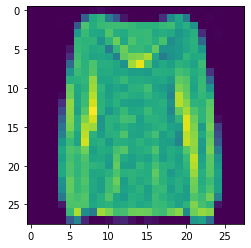

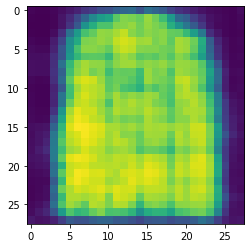

Embedded data points of the first 1000 images colored according to their class: 


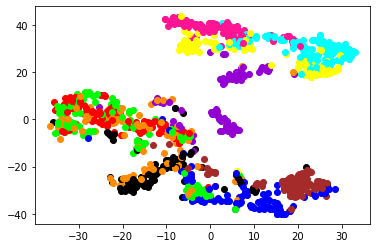

Training loss: 0.08257571
Test loss: 0.032861095
Interpolated example: 


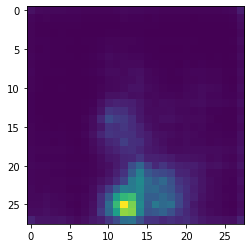

Epoch 1
Example image with its reconstructed counterpart: 


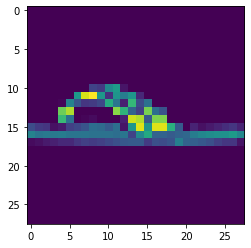

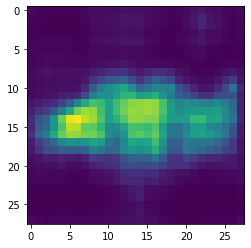

Embedded data points of the first 1000 images colored according to their class: 


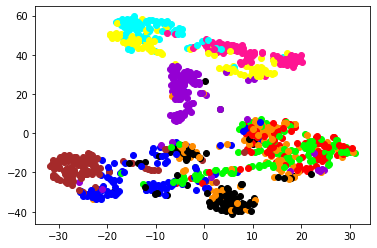

Training loss: 0.028416665
Test loss: 0.06480408
Interpolated example: 


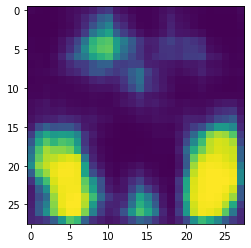

Epoch 2
Example image with its reconstructed counterpart: 


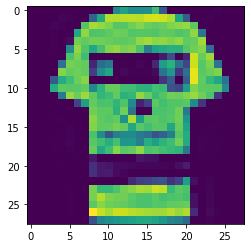

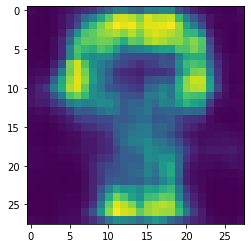

Embedded data points of the first 1000 images colored according to their class: 


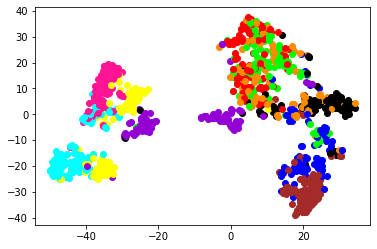

Training loss: 0.02725738
Test loss: 0.027301582
Interpolated example: 


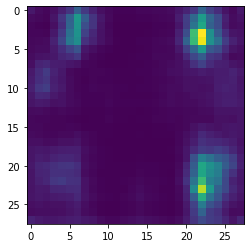

Epoch 3
Example image with its reconstructed counterpart: 


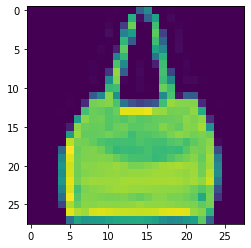

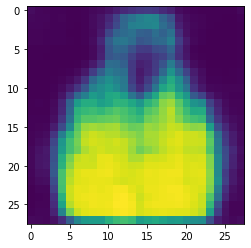

Embedded data points of the first 1000 images colored according to their class: 


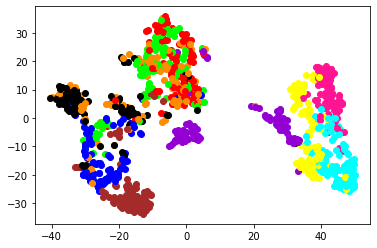

Training loss: 0.026476469
Test loss: 0.030047044
Interpolated example: 


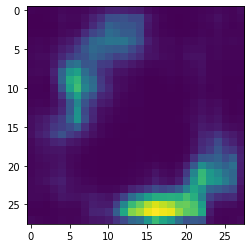

Epoch 4
Example image with its reconstructed counterpart: 


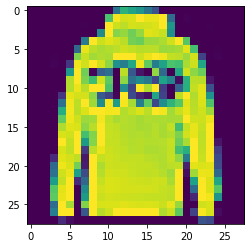

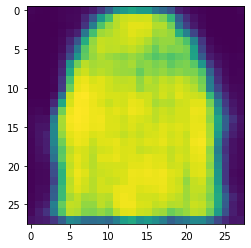

Embedded data points of the first 1000 images colored according to their class: 


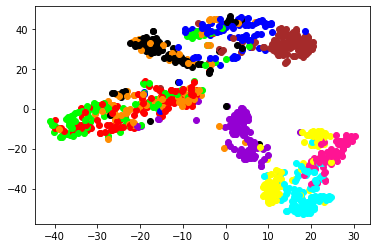

Training loss: 0.026151441
Test loss: 0.031178737
Interpolated example: 


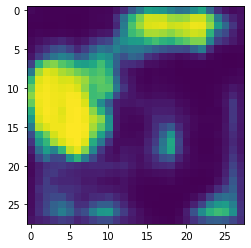

Epoch 5
Example image with its reconstructed counterpart: 


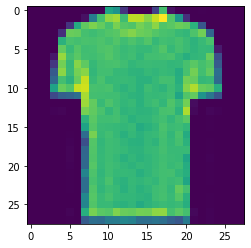

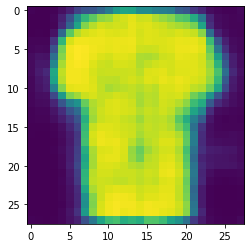

Embedded data points of the first 1000 images colored according to their class: 


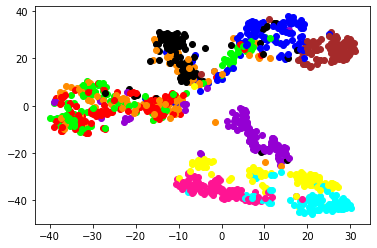

Training loss: 0.025734374
Test loss: 0.04149358
Interpolated example: 


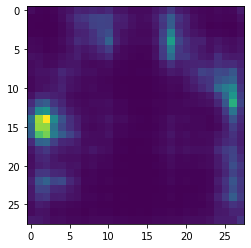

Epoch 6
Example image with its reconstructed counterpart: 


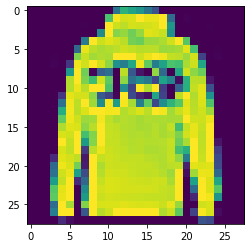

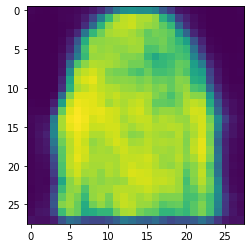

Embedded data points of the first 1000 images colored according to their class: 


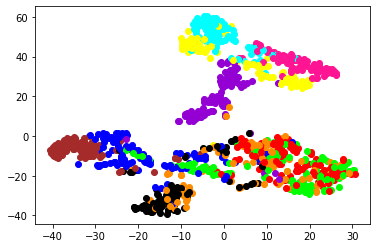

Training loss: 0.025348838
Test loss: 0.024097968
Interpolated example: 


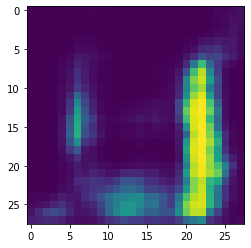

Epoch 7
Example image with its reconstructed counterpart: 


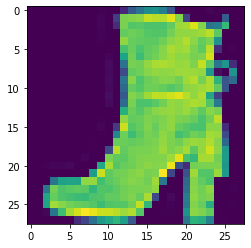

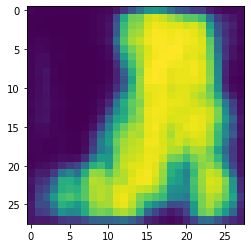

Embedded data points of the first 1000 images colored according to their class: 


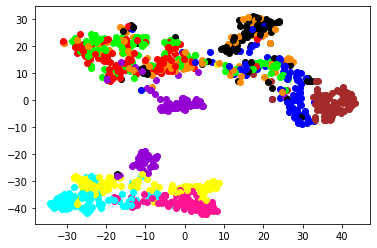

Training loss: 0.025154848
Test loss: 0.030763198
Interpolated example: 


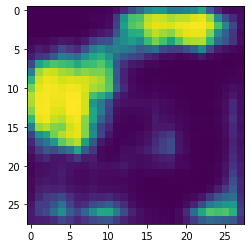

Epoch 8
Example image with its reconstructed counterpart: 


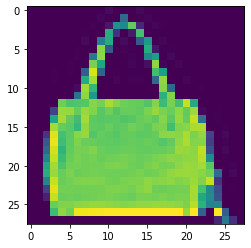

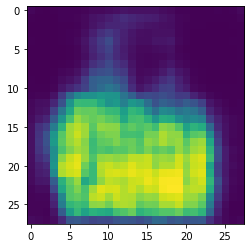

Embedded data points of the first 1000 images colored according to their class: 


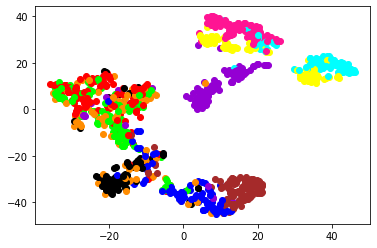

Training loss: 0.025030257
Test loss: 0.028992882
Interpolated example: 


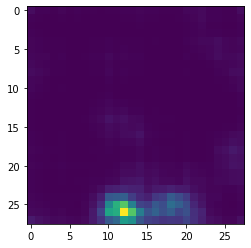

Epoch 9
Example image with its reconstructed counterpart: 


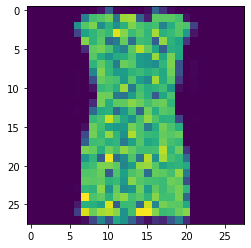

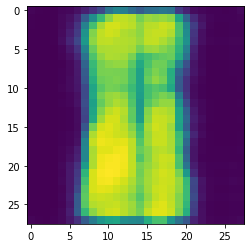

Embedded data points of the first 1000 images colored according to their class: 


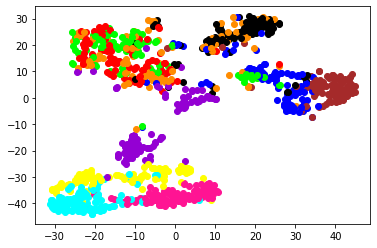

Training loss: 0.024903284
Test loss: 0.03576639
Interpolated example: 


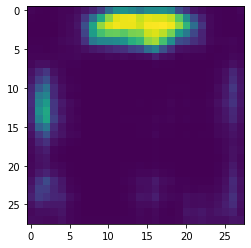

In [12]:
# Description: This part creates objects of ....... and executes the training and testing of these models in the training and test loop. The training 
#              takes place over an amount of epochs (n_epochs) with a predefined learning rate. The loss function defines the kind of loss-calculation. The optimizer 
#              is needed to adjust the gradients in the training steps. Moreover, the data for the visualization of the training and test progress is collected.
#              In order to better monitor the training progress, the loss and accuracy graphs are provided in addtion to the numerical outputs when the test accuracy 
#              has significantly improved.
tf.keras.backend.clear_session()

model = ConvAutoencoder()

n_epochs = 10
learning_rate = 0.00075
loss_fn = tf.keras.losses.MeanSquaredError()                             # Mean squared error as loss-function.
optimizer = tf.keras.optimizers.Adam((learning_rate), amsgrad = True)    # Optimizer Adam (Adaptive Moment Estimation) with AMSGrad activated.

training_losses = []
test_losses = []

# Training and test loop
for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    training_loss = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)

    test_loss, example_input_img, example_prediction_img, embeddings, corresponding_embedding_labels = test(model, test_dataset, loss_fn, training = False, interpolate_betw_two_embeddings = False)                              #, test_accuracy
    test_losses.append(test_loss)

    embeddings = tf.reshape(embeddings, [1000, 10])
    corresponding_embedding_labels = tf.reshape(corresponding_embedding_labels, [1000])
    reduced_embeddings = TSNE(n_components = 2).fit_transform(embeddings)

    # Example image with its reconstructed counterpart.
    print("Example image with its reconstructed counterpart: ")
    plt.imshow(tf.squeeze(example_input_img).numpy())
    plt.show()
    plt.imshow(tf.squeeze(example_prediction_img).numpy())
    plt.show()

    # Plots the embedded data points of the first 1000 images colored according to their class.
    print("Embedded data points of the first 1000 images colored according to their class: ")
    label_color_coding = ["black", "brown", "red", "blue", "lime", "yellow", "darkorange", "cyan", "darkviolet", "deeppink"]
    for embed in range(1000):
      current_label_color = label_color_coding[corresponding_embedding_labels[embed]]
      plt.scatter(reduced_embeddings[embed][0], reduced_embeddings[embed][1], color = current_label_color)
    plt.show()

    print("Training loss: " + str(training_loss))
    print("Test loss: " + str(test_loss))

    # Interpolates linearly between the embeddings of two images and plots the reconstructed image.
    print("Interpolated example: ")
    example_interpolated_prediction_img = test(model, test_dataset, loss_fn, training = False, interpolate_betw_two_embeddings = True)
    plt.imshow(tf.squeeze(example_interpolated_prediction_img).numpy())
    plt.show()

Visualization


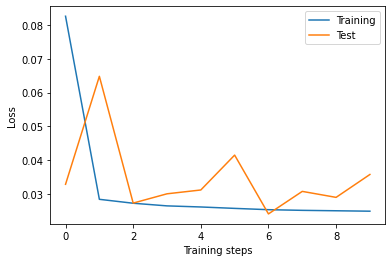

In [13]:
# Description: Figure 1 shows the loss for each epoch during the training and testing of the model.
#              Figure 2 shows the accuracy for each epoch during the training and testing of the model.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()